In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
run = 'barotropic_instabilities'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

fac_dt = 2
nx = 256
ny = 128
nt = 6000 * fac_dt

picture_frequency = 0
output_frequency = 60 * fac_dt
diagnostic_frequency = output_frequency

dx = 1e3
dy = dx

grav = 9.81
rho = np.array([1024.])
nz = rho.size

H0 = 1.
cph = np.sqrt(grav*H0)
#dist = dt*nt * cph
#dt  = 0.1*dx/np.sqrt(grav*H0)
dt = 60. / fac_dt
##dt = 360.

U0 = 1.
Ly = ny*dy
kmax = 0.4/(Ly/2.)
smax = 0.2*U0/(Ly/2.)
Lmax = 1./kmax
smax = 1./smax

print(f'Lmax = {Lmax/1e3}km, smax = {smax/86400.}days')
print(f'Tint = {nt*dt/86400.}days')

nspx = 1
nspy = 1
epsab = 0.01

iRe = 20e-3
kh = iRe*U0*dx
Ah = kh

f0 = 0.*1e-4
beta = 0.*1e-11

do_momentum_advection = True
do_momentum_diffusion = True

do_height_advection = True
do_upwind_advection = True
do_height_diffusion = False

do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = False
do_momentum_pressure_gradient = True

Lmax = 160.0km, smax = 3.7037037037037037days
Tint = 4.166666666666667days


In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
##ho0 = 0.01*(Xt-Lx/2.)/Lx
##ho0 = H0+0.1*np.sin(Xt/(Lx+dx)*2*np.pi*2)
#ho0 = H0+0.1 * np.tanh((Yt-0.5*Ly)/(0.2*Ly))
#ho0 = ho0[np.newaxis,:,:]
##H0 = 0.
##ho0 += H0
#
##uo0 = cph + 0.*Xu
##uo0 = uo0[np.newaxis,:,:]
#
#ho0 += 1e-6*np.random.randn((nz*ny*nx)).reshape(nz,ny,nx)
#
#uo0[:,1:-1,:] = -grav/fu0[:,1:-1,:]*(ho0[:,2:,:]-ho0[:,:-2,:])/(2*dy)
#
#uo0_yy = np.ma.zeros((nz,ny,nx))
#uo0_yy[:,1:-1,:] = (uo0[:,2:,:]-2.*uo0[:,1:-1,:]+uo0[:,:-2,:])/dy**2

uo0[:,:ny//2,:] = U0
uo0[:,ny//2:,:] = -U0
perturb = np.random.randn(nz*ny*nx).reshape(nz,ny,nx)
perturb *= 1e-1/perturb.max()
uo0 += perturb
vo0 += perturb

eta0[0,:,:] = 0
eta0[1,:,:] = -H0
#eta0 += perturb
ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

maskt0[:,0,:] = 0.
maskt0[:,-1,:] = 0.

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

ll =  11880/ 12000, Total run time: 2.75min, done at 2022-08-26 12:29:26.546589, ho.sum = 3.2e+04, ke.sum = 1.5e+04, cflu = 4.9e-02, cflv = 3.7e-02
--- All done! ---
Total run time: 2.75min, done at 2022-08-26 12:29:26.557178
------


## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [9]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    flist = glob.glob(f'{path_data}/{file_prfx}_????.nc')
    flist.sort()
    ds = xr.open_mfdataset(flist, **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/barotropic_instabilities//shallowpy_combined.nc
CPU times: user 1.88 s, sys: 746 ms, total: 2.63 s
Wall time: 2.2 s


## Plot overview

In [10]:
nps = ds.time.size
nps

100

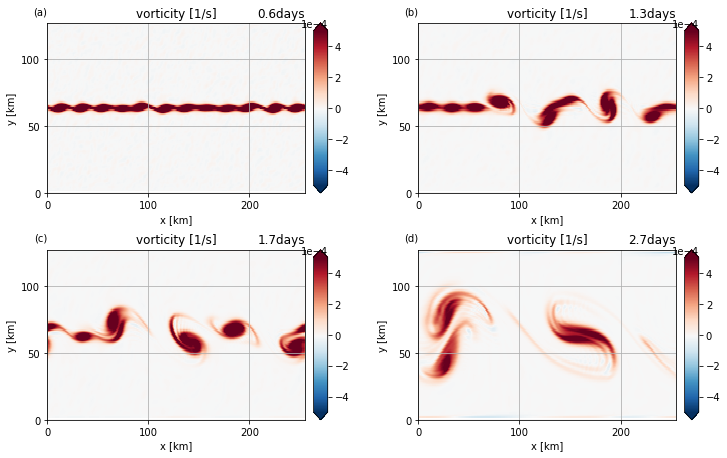

In [11]:
# prepare the animation
iz = 0
steps = [15, 30, 40, 65]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=0.66, fig_size_fac=1.5, 
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    # data = ds['uo'][ll,iz,:,:].compute()
    zeta = np.zeros((ny,nx))
    uo = ds.uo[ll,iz,:,:].to_masked_array()
    vo = ds.vo[ll,iz,:,:].to_masked_array()
    zeta[1:-1,1:-1] = (vo[1:-1,2:]-vo[1:-1,:-2])/dx - (uo[2:,1:-1]-uo[:-2,1:-1])/dy
    clim = 5e-4
    hm = shade(xu/1e3, yu/1e3, zeta, ax=ax, cax=cax, clim=clim)
    ax.set_title('vorticity [1/s]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')
    ax.grid(True)

## Make an animation

In [12]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/shallowpy_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

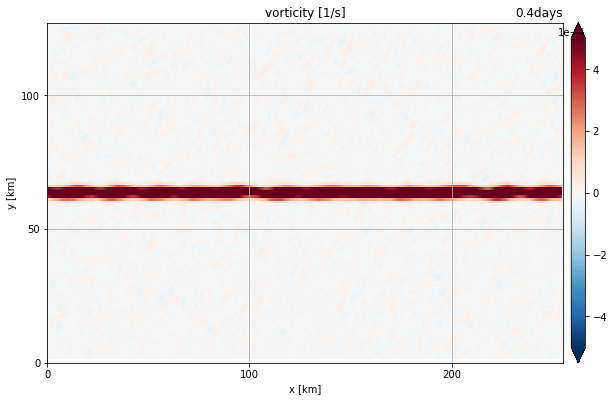

In [13]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=0.66, fig_size_fac=3, axlab_kw=None,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
uo = ds.uo[ll,iz,:,:].to_masked_array()
vo = ds.vo[ll,iz,:,:].to_masked_array()
zeta[1:-1,1:-1] = (vo[1:-1,2:]-vo[1:-1,:-2])/dx - (uo[2:,1:-1]-uo[:-2,1:-1])/dy
clim = 5e-4
hm = shade(xu/1e3, yu/1e3, zeta, ax=ax, cax=cax, clim=clim)
ax.set_title('vorticity [1/s]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')
ax.grid(True)

In [14]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    uo = ds.uo[ll,iz,:,:].to_masked_array()
    vo = ds.vo[ll,iz,:,:].to_masked_array()
    zeta[1:-1,1:-1] = (vo[1:-1,2:]-vo[1:-1,:-2])/dx - (uo[2:,1:-1]-uo[:-2,1:-1])/dy
    hm[0].set_array(zeta.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [15]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/barotropic_instabilities///barotropic_instabilities.mp4
CPU times: user 7.05 s, sys: 2.21 s, total: 9.26 s
Wall time: 9.33 s


## Showing the animation

In [16]:
%%time
HTML(ani.to_jshtml())

CPU times: user 8.73 s, sys: 2.24 s, total: 11 s
Wall time: 11 s
